# A neural network approach to solve Schrodinger equation

## Motivation:
[Universal approximation theorem](http://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html) proved that **ANY** function can be approximated by a neural network with one hidden layer, using a bounded, countinuous, monotonically increasing activation function [[Hornik](http://zmjones.com/static/statistical-learning/hornik-nn-1991.pdf)].

If the Schrodinger equation solver is formulated as the approximator to estimate molecular orbital coefficients, for a given basis set and assuming that the activation function satisfies the necessary condition. The limit of exact approximator exist. It is therefore interesting how well this approximator can be modeled.

## A naive network structure:
### input layer $\rightarrow$ recurrent hidden layer $\rightarrow$ output layer

* Input layer: Given basis set $\{g_{\alpha}(\mathbf{r})\}_{\alpha}$, and number of electrons $N$, and structure file, containing nuclear positions $\{\mathbf{R}_I\}_I$ and the correspoinding nuclear charge $\{Z_I\}_I$. Compute the following:
 * Overlap matrix $[\mathbf{S}]_{\alpha\beta}=\int d\mathbf{r} g_\alpha(\mathbf{r})g_\beta(\mathbf{r})$
 * Canonical orthogonalization matrix $\mathbf{X} = \mathbf{U} / \sqrt{\mathbf{D}}$
 * Kinetic energy matrix $[\mathbf{K}]_{\alpha\beta} = -\frac{1}{2}\int d\mathbf{r}g_\alpha(\mathbf{r})\nabla^2 g_\beta(\mathbf{r})$
 * External potential matrix $[\mathbf{V}]_{\alpha\beta} = -\sum_I\int d\mathbf{r}\frac{g_\alpha(\mathbf{r})g_\beta(\mathbf{r})}{|\mathbf{r} - \mathbf{R}_I|}Z_I$
 * Electron repulsion matrix $[\mathbf{ER}]_{\alpha\beta\gamma\delta} = \int d\mathbf{r} d\mathbf{r}'\frac{g_\alpha(\mathbf{r})g_\beta(\mathbf{r})g_\gamma(\mathbf{r}')g_\delta(\mathbf{r}')}{|\mathbf{r}-\mathbf{r}'|}$
 * Initialize molecular orbital coefficients (MOV) $\mathbf{C_0}$ (zero matrix), weights $\mathbf{W}$ (random matrix), and bias $\mathbf{b}$ (zero vector).
* Hidden recurrent layer: Given a maximum iteration number $T$, update MOV by the recursive function
$$
\mathbf{C}_{t} = \mathbf{\sigma}(\mathbf{C}_{t-1}\cdot\mathbf{W} + \mathbf{b}) = \mathbf{X}\cdot f_{\mathrm{eig}}\Big((\mathbf{C}_{t-1}\cdot\mathbf{W} + \mathbf{b})^{\mathrm{T}}\cdot(\mathbf{C}_{t-1}\cdot\mathbf{W} + \mathbf{b})\Big),
$$
where $\mathbf{\sigma}([\cdot]) = \mathbf{X}\cdot f_{\mathrm{eig}}([\cdot]^{\mathrm{T}}[\cdot]): \mathbb{R}^{m\times m}\rightarrow\mathbb{R}^{m\times m}$ is the nonlinear activation function.
Such that $\mathbf{C}_t^{\mathrm{T}}\cdot\mathbf{S}\cdot\mathbf{C}_t = \mathbf{1}\ \forall\ t$
(see section orthogonalization of the basis functions below).
* Output layer: Treat $\mathbf{C}_T$ as the converged Hartree-Fock molecular orbital coefficients and evaluate the Hartree-Fock energy normaly. That is (for conventional closed shell system)
$$
E = K + V + U + X + V_{nn},
$$
with density matrix $[\mathbf{P}]_{\alpha\beta}=2\sum_{i=1}^{N/2} C_{i\alpha}C_{i\beta}$ where 
 * Kinetic energy $K = tr(\mathbf{P}\cdot\mathbf{K})$
 * External pential energy $V = tr(\mathbf{P}\cdot\mathbf{V})$
 * and other terms $\cdots$

## Implementation

* Model construction:
All Gaussian basis matrix element can be evaluated by the ${\tt Horton}$ package. The computational graph (operational connectivity) can be constructed using ${\tt TensorFlow}$. 
* Trainning:
Standard backpropagation should work. There are two possible issues
 * Interface between ${\tt Horton}$ and ${\tt TensorFlow}$
 * Matrix operation derivatives, namely the derivative of trace and eigenvector decomposition in , e.g. $\frac{\partial K}{\partial\mathbf{W}} = \frac{\partial}{\partial\mathbf{W}} tr(\mathbf{P}\cdot\mathbf{K})$
 (see [/root_to_tensorflow/python/ops/linalg_grad.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/linalg_grad.py) and the corresponding [documentation](http://eprints.maths.ox.ac.uk/1079/1/NA-08-01.pdf) for details)

## Orthogonalization of the basis functions

Any random combination of Gaussian basis functions can be orthonormalized. An example of H$_2$ molecule using 3-21G basis function is shown

In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


Gaussian basis is normalized but not orthogonal to each other, as can be seen by the non-zero off-diagonal matrix element of the overlap matrix $\mathbf{S}$

In [3]:
mol.olp

array([[ 1.        ,  0.64589894,  0.40432958,  0.48051762],
       [ 0.64589894,  1.        ,  0.48051762,  0.8360078 ],
       [ 0.40432958,  0.48051762,  1.        ,  0.64589894],
       [ 0.48051762,  0.8360078 ,  0.64589894,  1.        ]])

However, the molecular orbitals (MO) form a orthonormal basis set,
$$
\langle\psi_i|\psi_j\rangle = \delta_{ij},
$$
where 
$$
\psi_i(\mathbf{r}) = \sum_{\alpha=1}^M c_{i\alpha}g_\alpha(\mathbf{r}),\mbox{ and MO coefficients } [\mathbf{C}]_{i\alpha} = c_{i\alpha}.
$$
That is
$$
\mathbf{C}^{\mathrm{T}}\cdot\mathbf{S}\cdot\mathbf{C} = \mathbf{1}
$$

In [4]:
C = mol.mov
C.T.dot(mol.olp).dot(C)

array([[  1.00000000e+00,  -2.22044605e-16,  -1.11022302e-16,
          2.22044605e-16],
       [ -2.77555756e-17,   1.00000000e+00,   1.11022302e-16,
         -3.33066907e-16],
       [ -1.66533454e-16,  -2.22044605e-16,   1.00000000e+00,
          2.22044605e-16],
       [ -3.46944695e-18,  -9.02056208e-16,   9.71445147e-17,
          1.00000000e+00]])

An orthornormalization matrix $\mathbf{X}$ can be constructed by the overlap matrix $\mathbf{S}$ (canonical orthogonization). 
$$
\mathbf{X} = \mathbf{U}\frac{1}{\sqrt{\mathbf{D}}},
$$
where $\mathbf{D}$ and $\mathbf{U}$ are the eigenvalues and eigenvectors of the overlap matrix $\mathbf{S}$.

Any random combination of basis function can be orothornormalized by orthornormalization matrix.

In [5]:
# canonical orthogonalization transformation matirx
D, U = np.linalg.eig(mol.olp)
X = U / np.sqrt(D)

# random MO coefficients
B = np.random.random(U.shape)
# orthonormalized MO coefficients
C = X.dot(np.linalg.eig(B.T.dot(B))[1])

# orthonormalized random MO coefficients
C.T.dot(mol.olp).dot(C)

array([[  1.00000000e+00,  -1.52655666e-16,   2.22044605e-16,
         -7.49400542e-16],
       [ -2.22044605e-16,   1.00000000e+00,   1.44328993e-15,
         -1.11022302e-16],
       [  2.22044605e-16,   1.45716772e-15,   1.00000000e+00,
          8.32667268e-16],
       [ -6.93889390e-16,  -6.59194921e-17,   6.80011603e-16,
          1.00000000e+00]])

## Construct H$_2$ dataset with varying bond length

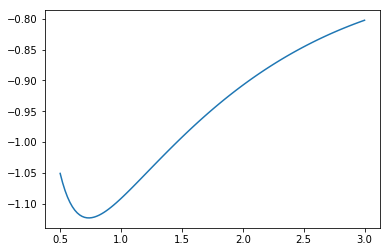

In [7]:
E = [inp.ht_ham.cache['energy'] for inp in inps]
R = [inp.molecule.R[1,0] for inp in inps]
plt.plot(R, E)

## Construct Tensorflow model 

In [8]:
import tensorflow as tf

In [17]:
def naive_net(mol):
    """
    Take qctoolkit horton input object as input, where all matrices are already calculated.
    Maybe it would be necessary to extract numpy matrix value and pass it as tf tensor.
    """
    
    # seems fine to pass molecule object and extract
    # Hamiltonian matrix components for energy evaluation
    S = tf.constant(mol.olp, shape=mol.olp.shape, name='overlap')
    K = tf.constant(mol.kin, shape=mol.kin.shape, name='kinetic')
    X = tf.constant(mol.X, shape=mol.X.shape, name='X')
    Er = tf.constant(mol.er, shape=mol.er.shape, name='electron_repulsion')
    
    MO = tf.Variable(tf.zeros_like(S), name='MO_coefficients_template')
    C = tf.Variable(MO.initialized_value(), name='MO_coeff')
    
    weights = tf.Variable(tf.truncated_normal(C.shape, dtype=tf.float64), name='weights_template')
    biases = tf.Variable(tf.zeros(C.shape[0], dtype=tf.float64), name='biases_template')
    W = tf.Variable(weights.initialized_value(), name="weights")
    b = tf.Variable(biases.initialized_value(), name="biases")
    
    
#     def update_C(C, W, b):
#         C_new = tf.add(tf.matmul(C, W), b)
#         C2_symm = tf.matmul(tf.transpose(C_new), C_new)
#         _, C = tf.self_adjoint_eig(C2_symm)
#         return C
#     C = update_C(C, W, b)
#     C = update_C(C, W, b)
#     C = update_C(C, W, b)
#     C = update_C(C, W, b)
        
    _, C = tf.self_adjoint_eig(
        tf.matmul(tf.transpose(tf.add(tf.matmul(C, W), b)), tf.add(tf.matmul(C, W), b))
    )
    
    
    return C

In [38]:
inps[0].olp.dot(inps[0].kin)

array([[ 2.27411819,  0.75751531,  1.94528249,  0.73365615],
       [ 1.85844375,  0.81621316,  1.77788087,  0.80852505],
       [ 1.94528249,  0.73365615,  2.27411819,  0.75751531],
       [ 1.77788087,  0.80852505,  1.85844375,  0.81621316]])

In [64]:
np.linalg.eig(inps[0].olp)[1][:,::1]

array([[-0.47147018, -0.52698754, -0.68114272,  0.18985415],
       [-0.52698754,  0.47147018, -0.18985415, -0.68114272],
       [-0.47147018, -0.52698754,  0.68114272, -0.18985415],
       [-0.52698754,  0.47147018,  0.18985415,  0.68114272]])